# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [22]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [24]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def get_roi(img):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # define vertices by four points
    xsize = img.shape[1]
    ysize = img.shape[0]
    left_bottom = (80, ysize)
    left_top = (xsize / 2 - 50, ysize / 2 + 50)
    right_bottom = (xsize - 80, ysize)
    right_top = (xsize / 2 + 50, ysize / 2 + 50)
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Read in an Image

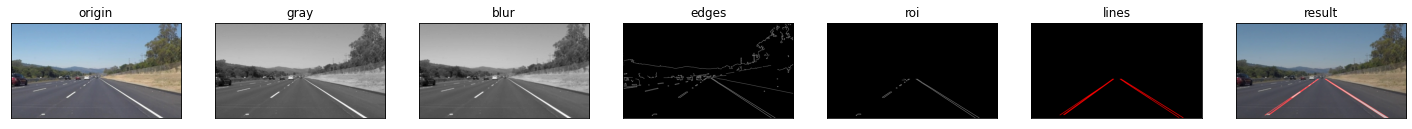

In [26]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
roi = get_roi(edges)
lines = hough_lines(roi, 2, np.pi / 180, 50, 100, 160)
result = cv2.addWeighted(image, 0.8, lines, 1., 0.)

plt.figure(figsize=(25,15))
plt.subplot(171), plt.imshow(image)
plt.title("origin"), plt.xticks([]), plt.yticks([])
plt.subplot(172), plt.imshow(gray, cmap='gray')
plt.title("gray"), plt.xticks([]), plt.yticks([])
plt.subplot(173), plt.imshow(blur, cmap='gray')
plt.title("blur"), plt.xticks([]), plt.yticks([])
plt.subplot(174), plt.imshow(edges, cmap='gray')
plt.title("edges"), plt.xticks([]), plt.yticks([])
plt.subplot(175), plt.imshow(roi, cmap='gray')
plt.title("roi"), plt.xticks([]), plt.yticks([])
plt.subplot(176), plt.imshow(lines, cmap='gray')
plt.title("lines"), plt.xticks([]), plt.yticks([])
plt.subplot(177), plt.imshow(result)
plt.title("result"), plt.xticks([]), plt.yticks([])
plt.show()

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

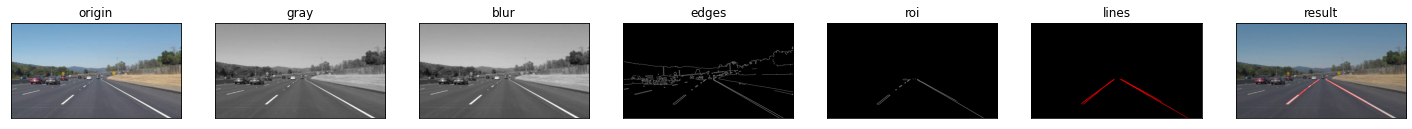

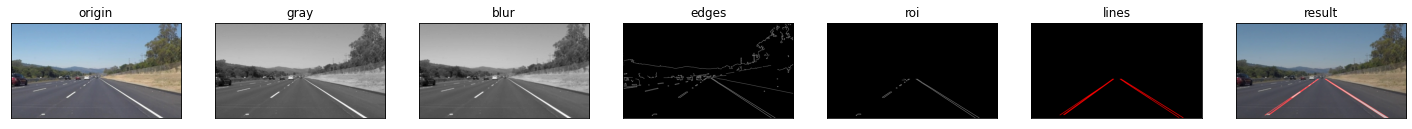

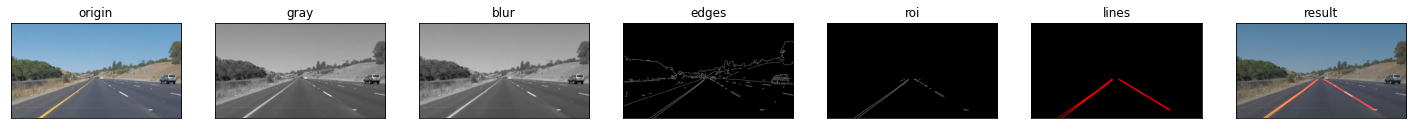

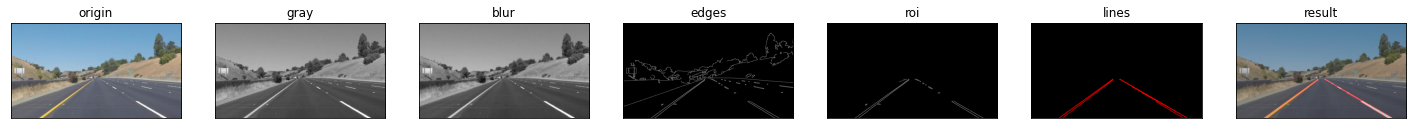

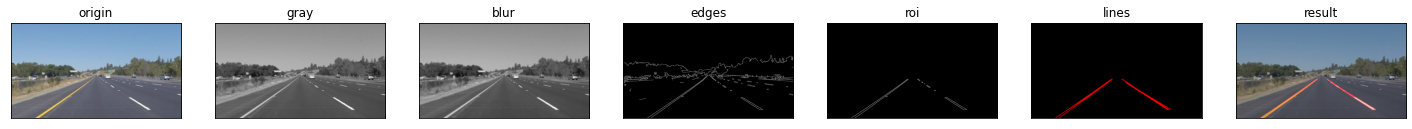

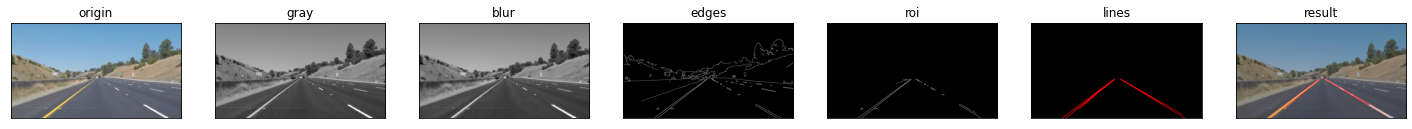

In [28]:
frames = os.listdir('test_images/')

for frame in frames:
    image = mpimg.imread("test_images/" + frame)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    roi = get_roi(edges)
    lines = hough_lines(roi, 2, np.pi / 180, 50, 100, 160)
    result = cv2.addWeighted(image, 0.8, lines, 1., 0.)

    plt.figure(figsize=(25,15))
    plt.subplot(171), plt.imshow(image)
    plt.title("origin"), plt.xticks([]), plt.yticks([])
    plt.subplot(172), plt.imshow(gray, cmap='gray')
    plt.title("gray"), plt.xticks([]), plt.yticks([])
    plt.subplot(173), plt.imshow(blur, cmap='gray')
    plt.title("blur"), plt.xticks([]), plt.yticks([])
    plt.subplot(174), plt.imshow(edges, cmap='gray')
    plt.title("edges"), plt.xticks([]), plt.yticks([])
    plt.subplot(175), plt.imshow(roi, cmap='gray')
    plt.title("roi"), plt.xticks([]), plt.yticks([])
    plt.subplot(176), plt.imshow(lines, cmap='gray')
    plt.title("lines"), plt.xticks([]), plt.yticks([])
    plt.subplot(177), plt.imshow(result)
    plt.title("result"), plt.xticks([]), plt.yticks([])
    plt.show()

## Test on Videos

In [30]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
def process_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 200)
    roi = get_roi(edges)
    lines = hough_lines(roi, 2, np.pi / 180, 50, 100, 160)
    result = cv2.addWeighted(image, 0.8, lines, 1., 0.)

    return result

Let's try the one with the solid white lane on the right first ...

In [34]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   6%|▌         | 13/221 [00:00<00:01, 126.22it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4


t:  43%|████▎     | 108/251 [04:29<00:01, 90.03it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 1.41 s


In [36]:
yellow_output = 'test_videos_output/yellow.mp4'
clips = VideoFileClip('test_videos/solidYellowLeft.mp4')
line_clips = clips.fl_image(process_image)
line_clips.write_videofile(yellow_output, audio=False)

t:   1%|▏         | 10/681 [00:00<00:06, 99.01it/s, now=None]Moviepy - Building video test_videos_output/yellow.mp4.
Moviepy - Writing video test_videos_output/yellow.mp4


t:  43%|████▎     | 108/251 [04:33<00:01, 90.03it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/yellow.mp4


## Improved lane finding pipeline

In [38]:
def divide_lines(img, lines):
    x_middle = img.shape[1] / 2
    all_left_lines = []
    all_right_lines = []
    left_lines = []
    right_lines = []
    
    for line in lines:
        if abs(line[0][0] - line[0][2]) > 2:
            k = (line[0][3] - line[0][1]) * 1.0 / (line[0][2] - line[0][0])
            if line[0][0] < x_middle and k < -0.5:
                all_left_lines.append(line[0])
            elif line[0][2] > x_middle and k > 0.5:
                all_right_lines.append(line[0])
                
    all_left_lines.sort(key=lambda x: x[0])
    all_right_lines.sort(key=lambda x: x[0])
    
    for line in all_left_lines:
        if len(left_lines) != 0:
            if line[0] > left_lines[-1][2] and line[1] < left_lines[-1][3]:
                left_lines.append([left_lines[-1][2], left_lines[-1][3], line[0], line[1]])
                left_lines.append([line[0], line[1], line[2], line[3]])
        else:
            left_lines.append([line[0], line[1], line[2], line[3]])

    for line in all_right_lines:
        if len(right_lines) != 0:
            if line[0] > right_lines[-1][2] and line[1] > right_lines[-1][3]:
                right_lines.append([right_lines[-1][2], right_lines[-1][3], line[0], line[1]])
                right_lines.append([line[0], line[1], line[2], line[3]])
        else:
            right_lines.append([line[0], line[1], line[2], line[3]])

    return left_lines, right_lines


def improved_lines(left_lines, right_lines, shape):
    ysize = shape[0]

    left_bottom = [left_lines[0][0], left_lines[0][1]]
    left_top = [left_lines[-1][2], left_lines[-1][3]]
    right_top = [right_lines[0][0], right_lines[0][1]]
    right_bottom = [right_lines[-1][2], right_lines[-1][3]]

    k_left = (left_top[1] - left_bottom[1]) * 1.0 / (left_top[0] - left_bottom[0])
    k_right = (right_top[1] - right_bottom[1]) * 1.0 / (right_top[0] - right_bottom[0])

    left_bottom2 = [int(left_bottom[0] - (left_bottom[1] - ysize) / k_left), ysize]
    left_top2 = [int(left_top[0] - (left_top[1] - (ysize / 2 + 50)) / k_left), int(ysize / 2 + 50)]
    right_bottom2 = [int(right_bottom[0] - (right_bottom[1] - ysize) / k_right), ysize]
    right_top2 = [int(right_top[0] - (right_top[1] - (ysize / 2 + 50)) / k_right), int(ysize / 2 + 50)]
    
    left_lines.append([left_bottom[0], left_bottom[1], left_bottom2[0], left_bottom2[1]])
    left_lines.append([left_top[0], left_top[1], left_top2[0], left_top2[1]])
    right_lines.append([right_bottom[0], right_bottom[1], right_bottom2[0], right_bottom2[1]])
    right_lines.append([right_top[0], right_top[1], right_top2[0], right_top2[1]])

    return left_lines, right_lines

def draw_lines2(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        cv2.line(img, (line[0], line[1]), (line[2], line[3]), color, thickness)
        

def improved_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    
    left_lines, right_lines = divide_lines(img, lines)
    left_lines, right_lines = improved_lines(left_lines, right_lines, img.shape)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines2(line_img, left_lines, [255, 0, 0], 10)
    draw_lines2(line_img, right_lines, [0, 255, 0], 10)

    return line_img

In [40]:
def improved_process_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 200)
    roi = get_roi(edges)
    lines = improved_hough_lines(roi, 2, np.pi / 180, 15, 5, 20)
    result = cv2.addWeighted(image, 0.8, lines, 1., 0.)
    return result

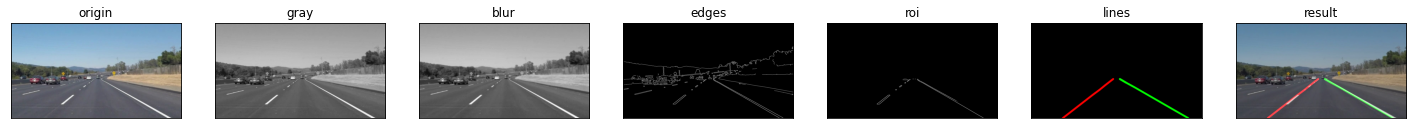

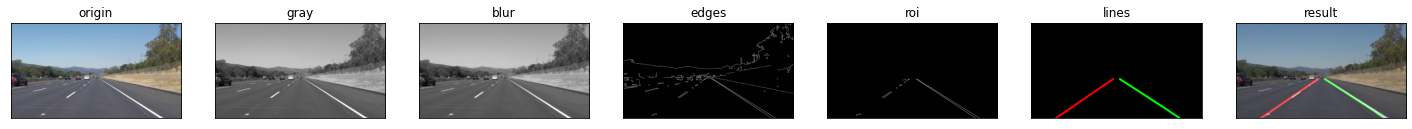

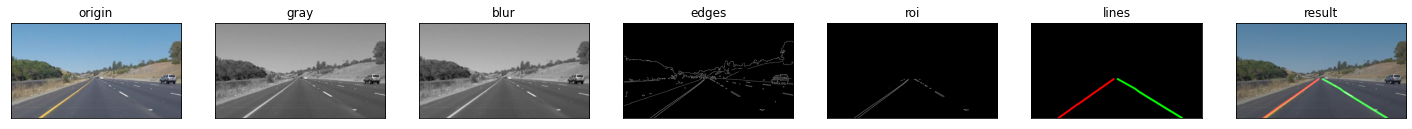

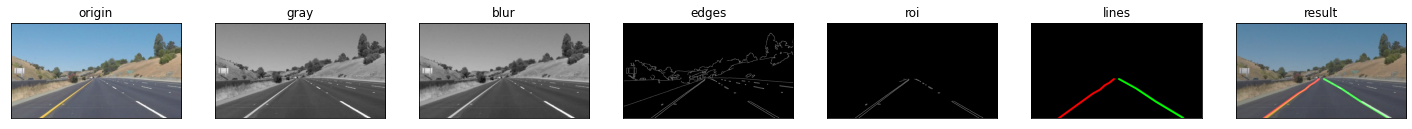

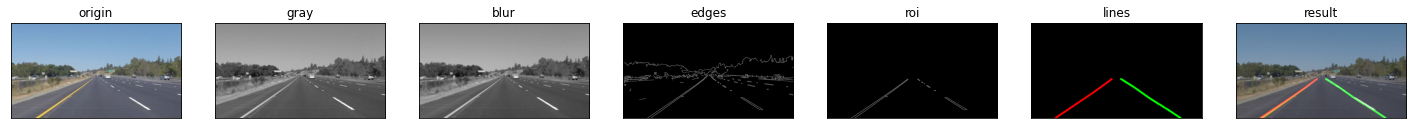

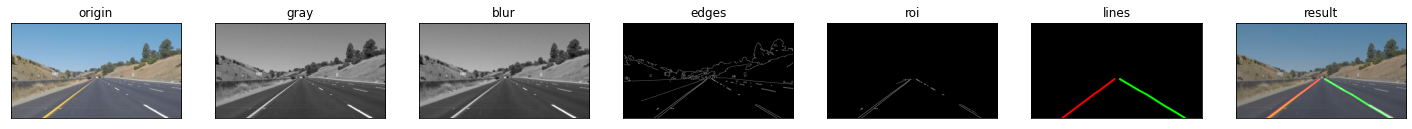

In [42]:
for frame in frames:
    image = mpimg.imread("test_images/" + frame)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    roi = get_roi(edges)
    lines = improved_hough_lines(roi, 2, np.pi / 180, 15, 5, 20)
    result = cv2.addWeighted(image, 0.8, lines, 1., 0.)

    plt.figure(figsize=(25,15))
    plt.subplot(171), plt.imshow(image)
    plt.title("origin"), plt.xticks([]), plt.yticks([])
    plt.subplot(172), plt.imshow(gray, cmap='gray')
    plt.title("gray"), plt.xticks([]), plt.yticks([])
    plt.subplot(173), plt.imshow(blur, cmap='gray')
    plt.title("blur"), plt.xticks([]), plt.yticks([])
    plt.subplot(174), plt.imshow(edges, cmap='gray')
    plt.title("edges"), plt.xticks([]), plt.yticks([])
    plt.subplot(175), plt.imshow(roi, cmap='gray')
    plt.title("roi"), plt.xticks([]), plt.yticks([])
    plt.subplot(176), plt.imshow(lines, cmap='gray')
    plt.title("lines"), plt.xticks([]), plt.yticks([])
    plt.subplot(177), plt.imshow(result)
    plt.title("result"), plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
white_output_improved = 'test_videos_output/white-improved.mp4'
clips = VideoFileClip("test_videos/solidWhiteRight.mp4")
line_clips = clips.fl_image(improved_process_image) 
line_clips.write_videofile(white_output_improved, audio=False)

yellow_output_improved = 'test_videos_output/yellow-improved.mp4'
clips = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clips.fl_image(improved_process_image)
%time yellow_clip.write_videofile(yellow_output_improved, audio=False)

HTML("""<video width="480" height="270" controls><source src="{0}">
</video>""".format(yellow_output_improved))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [41]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   3%|▎         | 7/251 [00:00<00:03, 68.29it/s, now=None]Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4


t:  43%|████▎     | 108/251 [04:46<00:01, 90.03it/s, now=None]Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 3.05 s


In [43]:
challenge_output = 'test_videos_output/challenge-improved.mp4'
clips = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clips.fl_image(improved_process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 6/251 [00:00<00:04, 57.69it/s, now=None]Moviepy - Building video test_videos_output/challenge-improved.mp4.
Moviepy - Writing video test_videos_output/challenge-improved.mp4


t:  40%|████      | 101/251 [00:01<00:01, 79.99it/s, now=None]

IndexError: list index out of range